In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


In [61]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()
plt.style.use("fivethirtyeight")

In [62]:
df= pd.read_csv("/content/AEP_hourly.csv")
df =df.set_index("Datetime")
df.index=pd.to_datetime(df.index)

In [63]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


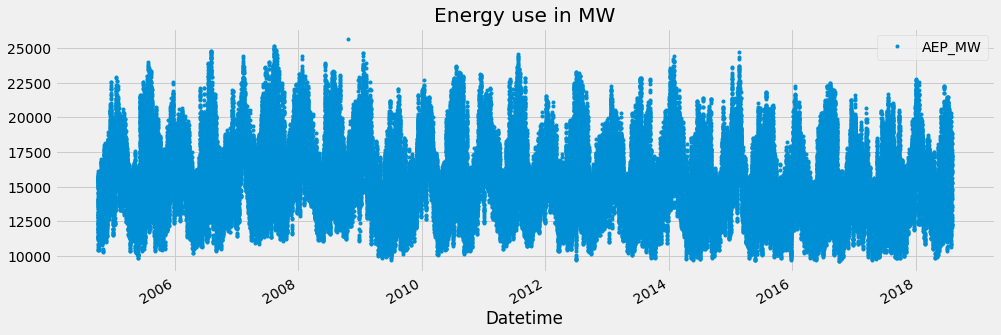

In [64]:
df.plot(style=".", figsize=(15,5),color=color_pal,title="Energy use in MW")
plt.show()

**Outlier analysis and removal**

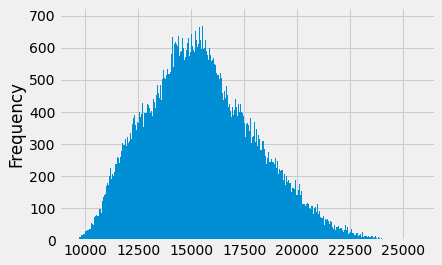

In [65]:
df["AEP_MW"].plot(kind="hist", bins=500)

**Checking for outliers below 9800 MW**

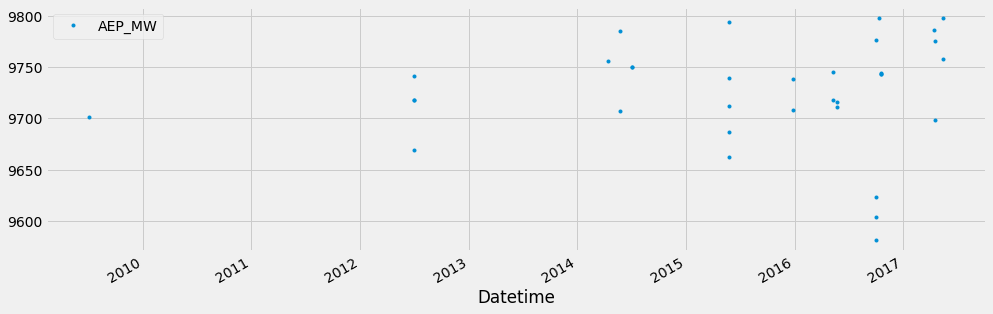

In [66]:
df.query('AEP_MW < 9800').plot(figsize=(15,5), style=".")

In [67]:
df = df.query('AEP_MW > 9800').copy()

In [68]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


**Training and Test Split**

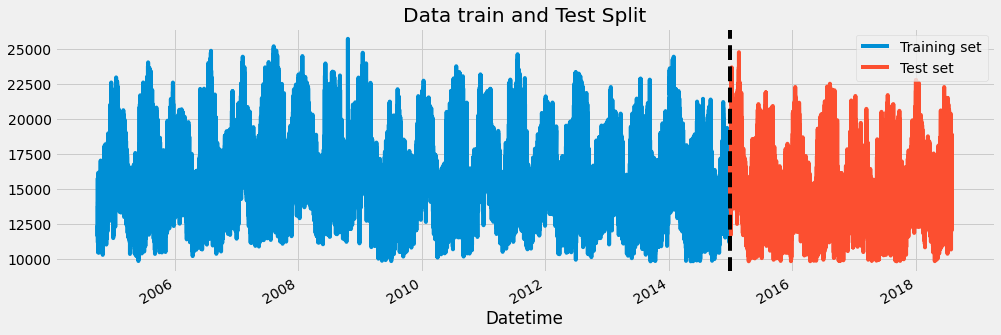

In [69]:
train = df.loc[df.index <"2015-01-01"]
test =df.loc[df.index >="2015-01-01"]
fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="Training Set",title="Data train and Test Split")
test.plot(ax=ax,label="Test Set")
ax.axvline("2015-01-01", color="black",ls="--")
ax.legend(["Training set","Test set"])
plt.show()

**Time series cross-validatios with sklearn**

In [70]:
from sklearn.model_selection import TimeSeriesSplit
Time_SeriesSplit= TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap=24)
#important part 
df = df.sort_index()

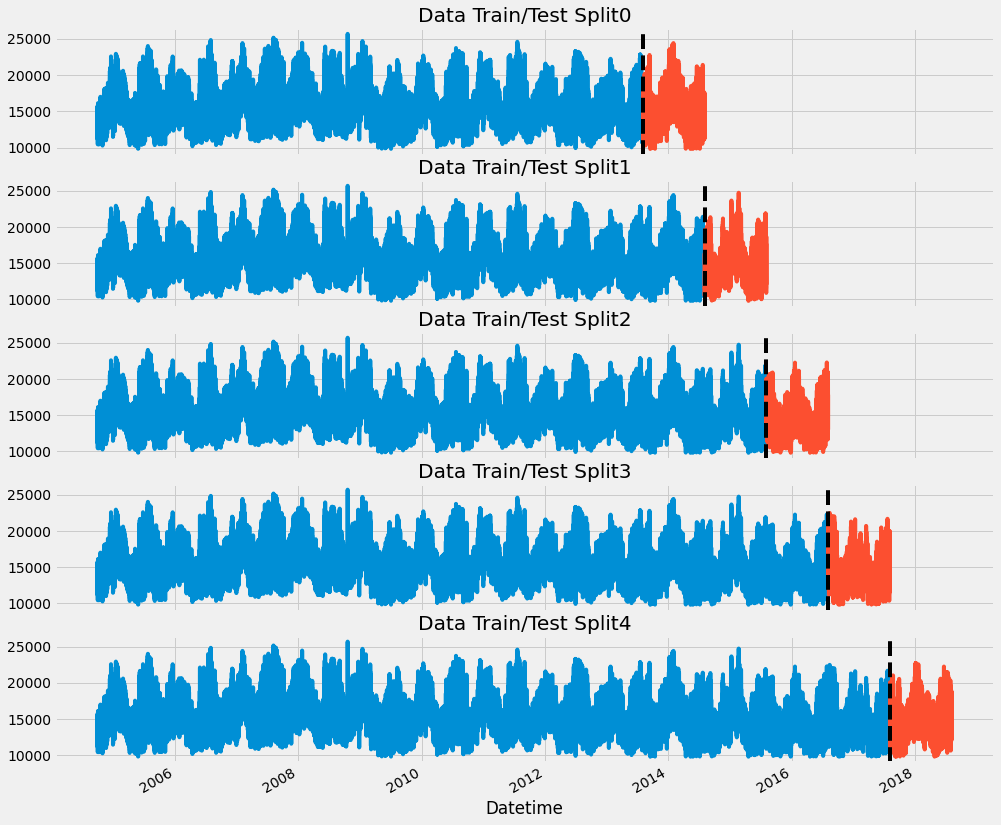

In [71]:
fig,axs=plt.subplots(5,1,figsize=(15,15),sharex=True)
fold=0
for train_indx, valid_indx in Time_SeriesSplit.split(df):
  train= df.iloc[train_indx]
  test=df.iloc[valid_indx]
  train["AEP_MW"].plot(ax=axs[fold],label="Training set",title=f"Data Train/Test Split{fold}")
  test["AEP_MW"].plot(ax=axs[fold],label="Test set")
  axs[fold].axvline(test.index.min(),color="black",ls="--")
  fold+=1
  if fold==5:
    break

**FORECSTING HORIZON**

In [72]:
def create_features(df):
  """
  create time series features based on time series index
  """

  df=df.copy()
  df["hour"]=df.index.hour
  df["dayofweek"]=df.index.dayofweek
  df["quarte"]=df.index.quarter
  df["month"]=df.index.month
  df["year"]=df.index.year
  df["dayofyear"]=df.index.dayofyear
  df["dayofmonth"]=df.index.day
  df["weekofyear"]=df.index.isocalendar().week
  return df


In [73]:
df=create_features(df)
df

,AEP_MW,hour,dayofweek,quarte,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,1,40
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,1,40
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,1,40
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,1,40
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,1,40
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31


**Lag features**

In [74]:
target_map =df["AEP_MW"].to_dict()

In [75]:
target_map

{Timestamp('2004-10-01 01:00:00'): 12379.0,
 Timestamp('2004-10-01 02:00:00'): 11935.0,
 Timestamp('2004-10-01 03:00:00'): 11692.0,
 Timestamp('2004-10-01 04:00:00'): 11597.0,
 Timestamp('2004-10-01 05:00:00'): 11681.0,
 Timestamp('2004-10-01 06:00:00'): 12280.0,
 Timestamp('2004-10-01 07:00:00'): 13692.0,
 Timestamp('2004-10-01 08:00:00'): 14618.0,
 Timestamp('2004-10-01 09:00:00'): 14903.0,
 Timestamp('2004-10-01 10:00:00'): 15118.0,
 Timestamp('2004-10-01 11:00:00'): 15242.0,
 Timestamp('2004-10-01 12:00:00'): 15375.0,
 Timestamp('2004-10-01 13:00:00'): 15404.0,
 Timestamp('2004-10-01 14:00:00'): 15655.0,
 Timestamp('2004-10-01 15:00:00'): 15739.0,
 Timestamp('2004-10-01 16:00:00'): 15739.0,
 Timestamp('2004-10-01 17:00:00'): 15644.0,
 Timestamp('2004-10-01 18:00:00'): 15353.0,
 Timestamp('2004-10-01 19:00:00'): 15034.0,
 Timestamp('2004-10-01 20:00:00'): 15211.0,
 Timestamp('2004-10-01 21:00:00'): 15349.0,
 Timestamp('2004-10-01 22:00:00'): 14837.0,
 Timestamp('2004-10-01 23:00:00'

In [81]:
def add_lags(df):
  df["lag1"]=(df.index-pd.Timedelta("364 days")).map(target_map)
  df["lag2"]=(df.index-pd.Timedelta("728 days")).map(target_map)
  df["lag3"]=(df.index-pd.Timedelta("1092 days")).map(target_map)
  return df

In [82]:
add_lags(df)

,AEP_MW,hour,dayofweek,quarte,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,1,40,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,1,40,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,1,40,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,1,40,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,1,40,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18705.0,20140.0,16078.0
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18108.0,19616.0,15908.0
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17544.0,19246.0,15783.0


In [96]:
df=df.drop(columns="weekofyear")

In [100]:

fold=0
pred=[]
scores=[]
for train_indx, valid_indx in Time_SeriesSplit.split(df):
  train= df.iloc[train_indx]
  test=df.iloc[valid_indx]

  train=create_features(train)
  test=create_features(test)

  FEATURES= ['hour', 'dayofweek', 'quarte', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1', 'lag2', 'lag3']
  TARGET= ["AEP_MW"]
  X_train=train[FEATURES]
  y_train=train[TARGET]

  X_test=test[FEATURES]
  y_test=test[TARGET]


  reg=xgb.XGBRegressor(base_score=0.5, booster="gbtree",n_estimators=1000,early_stopping_rounds=50,objective="reg:linear",max_depth=3,learning_rate=0.01)
  reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

  y_pred =reg.predict(X_test)
  pred.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test,y_pred))
  scores.append(score)

[15:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15898.8	validation_1-rmse:15268.7
[100]	validation_0-rmse:6031.09	validation_1-rmse:5643.63
[200]	validation_0-rmse:2654.85	validation_1-rmse:2429.27
[300]	validation_0-rmse:1709.22	validation_1-rmse:1643.24
[400]	validation_0-rmse:1489.58	validation_1-rmse:1553.84
[500]	validation_0-rmse:1428.72	validation_1-rmse:1564.25
[600]	validation_0-rmse:1397.31	validation_1-rmse:1564.43
[700]	validation_0-rmse:1377.26	validation_1-rmse:1555.26
[800]	validation_0-rmse:1362.12	validation_1-rmse:1550.31
[900]	validation_0-rmse:1342.35	validation_1-rmse:1549.23
[999]	validation_0-rmse:1327.36	validation_1-rmse:1554.84
[15:21:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15836.7	validation_1-rmse:15215.4
[100]	validation_0-rmse:6008.06	validation_1-rmse:5713

In [ ]:
print(f"score cross folds {np.mean(scores):0.4f} ")
print(f"Fold scores : {scores}")

Predicting the future

In [101]:
# retrain the model again
df = create_features(df)
FEATURES= ['hour', 'dayofweek', 'quarte', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1', 'lag2', 'lag3']
TARGET= ["AEP_MW"]
X_all=train[FEATURES]
y_all=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]


reg=xgb.XGBRegressor(base_score=0.5, booster="gbtree",n_estimators=500,early_stopping_rounds=50,objective="reg:linear",max_depth=3,learning_rate=0.01)
reg.fit(X_all,y_all,eval_set=[(X_all,y_all)],verbose=100)


[16:21:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15602.3
[100]	validation_0-rmse:5925.4
[200]	validation_0-rmse:2626.61
[300]	validation_0-rmse:1717.77
[400]	validation_0-rmse:1514.25
[499]	validation_0-rmse:1459


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=500)

In [102]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [106]:
#create future
future =pd.date_range(start="2018-08-03", end="2019-08-01",freq="1h")
future_df=pd.DataFrame(index=future)
future_df["isFuture"]=True
df["isFuture"]=False
df_and_futuredf=pd.concat([df,future_df])
df_and_futuredf= create_features(future_df)
df_and_futuredf= add_lags(df_and_futuredf)

In [107]:
df_and_futuredf

,isFuture,hour,dayofweek,quarte,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
2018-08-03 00:00:00,True,0,4,3,8,2018,215,3,31,15045.0,16491.0,13669.0
2018-08-03 01:00:00,True,1,4,3,8,2018,215,3,31,13940.0,15319.0,12772.0
2018-08-03 02:00:00,True,2,4,3,8,2018,215,3,31,13230.0,14492.0,12253.0
2018-08-03 03:00:00,True,3,4,3,8,2018,215,3,31,12624.0,13945.0,11928.0
2018-08-03 04:00:00,True,4,4,3,8,2018,215,3,31,12410.0,13619.0,11696.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,True,20,2,3,7,2019,212,31,31,16579.0,18495.0,20026.0
2019-07-31 21:00:00,True,21,2,3,7,2019,212,31,31,16457.0,17771.0,19529.0
2019-07-31 22:00:00,True,22,2,3,7,2019,212,31,31,16197.0,17220.0,19029.0
2019-07-31 23:00:00,True,23,2,3,7,2019,212,31,31,15259.0,16100.0,17790.0


In [109]:
future_with_features=df_and_futuredf.query('isFuture==True').copy()

In [112]:
future_with_features= future_with_features.drop(columns="isFuture")

In [113]:
future_with_features

,hour,dayofweek,quarte,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,15045.0,16491.0,13669.0
2018-08-03 01:00:00,1,4,3,8,2018,215,3,31,13940.0,15319.0,12772.0
2018-08-03 02:00:00,2,4,3,8,2018,215,3,31,13230.0,14492.0,12253.0
2018-08-03 03:00:00,3,4,3,8,2018,215,3,31,12624.0,13945.0,11928.0
2018-08-03 04:00:00,4,4,3,8,2018,215,3,31,12410.0,13619.0,11696.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,16579.0,18495.0,20026.0
2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,16457.0,17771.0,19529.0
2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,16197.0,17220.0,19029.0
2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,15259.0,16100.0,17790.0


array([14422.125, 13655.834, 13103.562, ..., 17330.4  , 16447.012,
       14420.832], dtype=float32)

In [115]:
future_with_features["predicted"]=reg.predict(future_with_features[FEATURES])

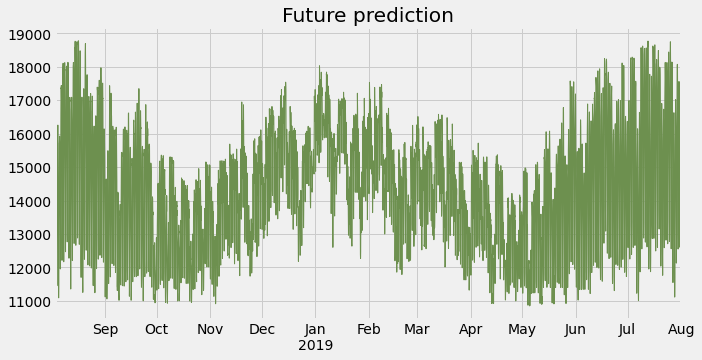

In [120]:
future_with_features["predicted"].plot(figsize=(10,5),color=color_pal[3],ms=1,
                                       lw=1,
                                       title="Future prediction")
plt.show()

**Saving the model**

In [121]:
reg.save_model("XGBmodel.json")